# OPGP: Laplace's equation example

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax.config import config
config.update("jax_enable_x64", True)  # enable double precision (very important)

import opgp
from opgp import build_solve
from opgp import build_predict, build_predict_scalar

TODO emphasize
- bring your own data (not limited to input grids)
- bring your own kernel function (smoothness, symmetries, ...)
- Novelty: bring your own __algorithmic operators__ (gradients, hessians, directional derivatives, Taylor series, ...) e.g. from knowing a PDE


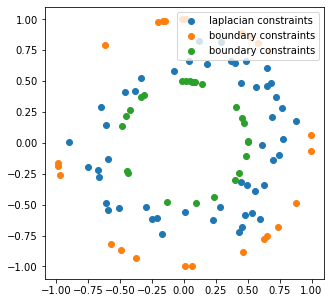

In [2]:
def sample_annulus(plot=False,
                   radius_outer=1.0,
                   radius_inner=0.5,
                   n_interior=50,
                   n_boundary=50,
                   gap=0.1,
                   rng=jax.random.PRNGKey(1234)):
    rng, key1, key2, key3, key4 = jax.random.split(rng, 5)
    radii = jnp.sqrt(jax.random.uniform(key1, (n_interior,), minval=(radius_inner * (1+gap))**2, maxval=(radius_outer * (1-gap))**2))
    angles = jax.random.uniform(key2, (n_interior,)) * 2 * jnp.pi
    x_interior = jax.vmap(lambda r, theta:   r * jnp.array([jnp.cos(theta), jnp.sin(theta)]))(radii, angles)
    x_boundary_outer = jax.vmap(lambda theta: radius_outer * jnp.array([jnp.cos(theta), jnp.sin(theta)]))(jax.random.uniform(key3, (n_boundary // 2,)) * 2 * jnp.pi)
    x_boundary_inner = jax.vmap(lambda theta: radius_inner * jnp.array([jnp.cos(theta), jnp.sin(theta)]))(jax.random.uniform(key4, (n_boundary // 2,)) * 2 * jnp.pi)
    if plot:
        plt.figure(figsize=(5,5))
        plt.scatter(*x_interior.T, label="laplacian constraints")
        plt.scatter(*x_boundary_outer.T, label="boundary constraints")
        plt.scatter(*x_boundary_inner.T, label="boundary constraints")
        plt.legend(loc="upper right")
    x = {
        "interior": x_interior, 
        "boundary_outer": x_boundary_outer,
        "boundary_inner": x_boundary_inner,
    }
    return x

sample_annulus(plot=True);

In [3]:
# define your own kernel
def rbf(x1, x2, lengthscale=1.0):
    return jnp.exp(-0.5 * jnp.sum((x1-x2)**2) / lengthscale**2)

# define your own operators
def identity(f):
    return f

def laplacian(f):
    def Δf(x):
        return jnp.trace(jax.hessian(f)(x))
    return Δf

def disknormal_derivative(f):
    def df_dn(x):
        n = x / jnp.linalg.norm(x) # normal vectors on a zero-centered disk are easy
        return jax.jvp(f, (x,), (n,))[1]
    return df_dn

def boundary_outer_function(x):
    return jnp.cos(5*jnp.arctan2(x[1], x[0]))

# gather your data (or in this case: sample observations at locations from the domain)
def sample_laplace_annulus_example(n_interior=50,
                                   n_boundary=50,
                                   gap=0.1,
                                   rng=jax.random.PRNGKey(1234)):
    x = sample_annulus(n_interior=n_interior, n_boundary=n_boundary, gap=gap, rng=rng)
    operators = {
        "interior": laplacian,
        "boundary_inner": identity,
        "boundary_outer": disknormal_derivative,
    }
    observations = {
        "interior": jnp.zeros(len(x["interior"])),
        "boundary_inner": jnp.zeros(len(x["boundary_inner"])),
        "boundary_outer": jax.vmap(boundary_outer_function)(x["boundary_outer"]),
    }
    return operators, x, observations

## A general linear operator equation

$$
\mathcal L_x f(x)  = g(x)
$$
where $f: \Omega \to \mathbb{R}$, $g: \Omega \to \mathbb{R}^d$ and $\mathcal L$ a linear operator in the sense $\mathcal L(af_1 + bf_2) = a\mathcal L(f_1) + b \mathcal L(f_2)$ for $a,b\in\mathbb{R}$.

## A small example PDE: Laplace equation

We solve a Laplace equation (1) on an annulus domain $\Omega$, with Dirichlet conditions (2) on the inner boundary $\partial\Omega_1$ and Neumann conditions (3) on the outer boundary $\partial\Omega_2$ in terms of the angle $\theta$ of $x$ to the $x_1$-axis.

\begin{align*}
    \Delta f(x) &= 0 & x\in\Omega\hphantom{10}\\
    f(x) &= 0 & x\in\partial\Omega_1\\
    n(x) \cdot \nabla f(x) &= 4\cos (5 \theta) & x\in\partial\Omega_2
\end{align*}

The setup is similar to the example on Wikipedia https://en.wikipedia.org/wiki/Laplace%27s_equation but uses Neumann BC on the outer circle instead of Dirichlet.

## The kernel regression formulation

Sampling the domain and boundary, we can view observations as triplets $(\mathcal L_m, x_m, y_m)$, where we include knowledge of the linear operator itself as data. Note that $\mathcal L_m$ can be different for each sample, and from the PDE above here we choose accordingly

$$
\mathcal L_m = 
\begin{cases}
    \Delta & x_m \in\Omega\hphantom{10}\\
    id     & x_m \in\partial\Omega_1\\
    n(x_m) \cdot \nabla & x_m\in\partial\Omega_2
\end{cases}
$$

An empirical regularized risk functional to be minimized by the model is formulated as follows: 

$$
L[f] = \sum_m^M \tfrac{1}{2} ||y_m - \mathcal L_m f(x_m)||^2 + \tfrac{\lambda}{2} ||f||^2_{\mathcal H}
$$

Representing $f$ by choice of kernel $k$ takes the form:
$$
f(x) = \sum_m^M \alpha_m \cdot \mathcal L_m k(x_m, x)
$$
The optimal coefficients $\alpha$ are then found by solving a linear system arising from $\nabla_\alpha L \stackrel{!}{=}0$: We solve
$$(K + \lambda I) \alpha = y$$
where $(K)_{mm'} := \mathcal L_m k(x_m, x_{m'}) \mathcal L_{m'}' \in \mathbb{R}^{dim(y_m)\times dim(y_{m'})}$ and we stack $\alpha = [\alpha_m]_{m=1}^M$ and $y=[y_m]_{m=1}^M$.

### Summary

To summarise all the moving parts: We have
- data triplets $(\mathcal L_m, x_m, y_m)$, represented in code as three dictionaries `operators`, `x`, `observations` of matching keys.
    - $\mathcal L_m$ are represented as __algorithmic operators__: they are higher-order functions (and can make use of AD internally, but could also include e.g. finite differencing or numerical integration).
- a kernel $k$ represented as a scalar-valued python function `kernel(x1, x2)`

Now we combine these ingredients within the `fit` function in three steps:
1. `build_solve` automatically assembles the solver based on the user-supplied kernel and user-supplied algorithmic operators.
2. `solve` computes the optimal coefficients alpha by solving the linear system.
3. `build_predict_scalar` combines the solution into a predictive scalar function representing a solution `f`.

In [4]:
def fit(k, operators, x, observations):
    solve = build_solve(k, operators, solver="cholesky")
    alphas = solve(x, observations)
    f = build_predict_scalar(k, operators, x, alphas)
    return f

operators, x, observations = sample_laplace_annulus_example()
kernel = rbf
f = fit(kernel, operators, x, observations)

In [5]:
def mse(a, b):
    return jnp.mean((a - b)**2)

def evaluate_errors(f, operators, x, observations):
    return {opkey: mse(jax.vmap(op(f))(x[opkey]), observations[opkey]) 
            for (opkey, op) in operators.items()}

# train error
evaluate_errors(f, operators, x, observations)

{'interior': DeviceArray(2.39309948e-08, dtype=float64),
 'boundary_inner': DeviceArray(1.46805593e-05, dtype=float64),
 'boundary_outer': DeviceArray(1.74803564e-08, dtype=float64)}

In [6]:
# test error
_, x_test, observations_test = sample_laplace_annulus_example(n_boundary=200,
                                                              n_interior=2000,
                                                              gap=0,
                                                              rng=jax.random.PRNGKey(5678))
evaluate_errors(f, operators, x_test, observations_test)

{'interior': DeviceArray(0.00609327, dtype=float64),
 'boundary_inner': DeviceArray(2.18688658e-05, dtype=float64),
 'boundary_outer': DeviceArray(0.00011067, dtype=float64)}

Text(0.5, 1.0, 'reconstructed f')

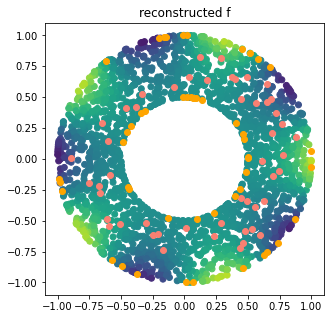

In [7]:
plt.figure(figsize=(5,5))
vmin = -0.25
vmax = 0.25
plt.scatter(*x_test["interior"].T, c=jax.vmap(f)(x_test["interior"]), vmin=vmin, vmax=vmax)
plt.scatter(*x_test["boundary_outer"].T, c=jax.vmap(f)(x_test["boundary_outer"]), vmin=vmin, vmax=vmax)
plt.scatter(*x_test["boundary_inner"].T, c=jax.vmap(f)(x_test["boundary_inner"]), vmin=vmin, vmax=vmax)
plt.scatter(*x["interior"].T, c="salmon")
plt.scatter(*x["boundary_outer"].T, c="orange")
plt.scatter(*x["boundary_inner"].T, c="orange")
plt.title("reconstructed f")